In [1]:
from poola import core as pool
import pandas as pd
import seaborn as sns
import gpplot as gpp
import matplotlib.pyplot as plt
gpp.set_aesthetics(context = 'paper')

In [2]:
#define paths
file_path = "../../Data/primaryLibrary/"
figure1_outpath = '../../Figures/Figure 1/'

In [3]:
#read in read counts
file = file_path + 'counts-SM20231201.txt'
HCT116_Zim3 = pd.read_table(file)

In [4]:
HCT116_Zim3.head()

,Construct Barcode,Construct IDs,HCT116_RDB182_RepA,Unlabeled Sample Barcodes,pDNA CP1948,HCT116_RDB182_RepB
0,ATAGCGACGTCCGTTGGACA,ATAGCGACGTCCGTTGGACA,449,0,53,459
1,ACCCGGACTACGCCATGTTG,ACCCGGACTACGCCATGTTG,93,0,97,105
2,AGTACCCCTATTCAACCGGA,AGTACCCCTATTCAACCGGA,508,0,74,755
3,TAATCAGAGGAACTACGTTT,TAATCAGAGGAACTACGTTT,527,0,89,499
4,TATGGCTGTCACCTAGATCA,TATGGCTGTCACCTAGATCA,325,0,41,348


In [5]:
#read in design file
design_file = file_path + 'essentials_nonessentials_CRISPRi_tiling_designs_v2.csv'
ess_noness = pd.read_csv(design_file)
ess_noness = ess_noness[['Target Gene Symbol','Target Gene ID','Category','TSS Position', 
       'sgRNA \'Cut\' Site TSS Offset','sgRNA Sequence', 
           'sgRNA Context Sequence', 'On-Target Ruleset',
       'On-Target Efficacy Score']]
ess_noness.head()

,Target Gene Symbol,Target Gene ID,Category,TSS Position,sgRNA 'Cut' Site TSS Offset,sgRNA Sequence,sgRNA Context Sequence,On-Target Ruleset,On-Target Efficacy Score
0,ATP5F1B,506.0,Essential,56645984.0,-255.0,ATAGCGACGTCCGTTGGACA,GATCATAGCGACGTCCGTTGGACAGGGTAA,RS3seq-Chen2013,0.9257
1,ATP5F1B,506.0,Essential,56645984.0,24.0,ACCCGGACTACGCCATGTTG,CTCCACCCGGACTACGCCATGTTGGGGTTT,RS3seq-Chen2013,0.7588
2,ATP5F1B,506.0,Essential,56645984.0,396.0,AGTACCCCTATTCAACCGGA,GTTCAGTACCCCTATTCAACCGGAAGGTCA,RS3seq-Chen2013,0.7492
3,ATP5F1B,506.0,Essential,56645984.0,-278.0,TAATCAGAGGAACTACGTTT,AGGGTAATCAGAGGAACTACGTTTAGGAAA,RS3seq-Chen2013,0.7506
4,ATP5F1B,506.0,Essential,56645984.0,-362.0,TATGGCTGTCACCTAGATCA,CCCCTATGGCTGTCACCTAGATCAAGGACC,RS3seq-Chen2013,0.9978


In [6]:
#calculate log-normalized reads, filter guides with low representation in pDNA
lognorms_HCT116_Zim3 = pool.lognorm_columns(reads_df=HCT116_Zim3, columns=['HCT116_RDB182_RepA','pDNA  CP1948', 'HCT116_RDB182_RepB'])
filtered_lognorms_lognorms_HCT116_Zim3 = pool.filter_pdna(lognorm_df=lognorms_HCT116_Zim3, pdna_cols=['pDNA  CP1948'], z_low=-3)
print('Filtered ' + str(lognorms_HCT116_Zim3.shape[0] - filtered_lognorms_lognorms_HCT116_Zim3.shape[0]) + ' rows due to low pDNA abundance')

Filtered 662 rows due to low pDNA abundance


In [7]:
#calculate log-fold changes
lfc_df_HCT116_Zim3 = pool.calculate_lfcs(lognorm_df=filtered_lognorms_lognorms_HCT116_Zim3, 
                                         ref_col='pDNA  CP1948', target_cols=['HCT116_RDB182_RepA', 'HCT116_RDB182_RepB'])
lfc_df_HCT116_Zim3.head()

,Construct Barcode,Construct IDs,HCT116_RDB182_RepA,Unlabeled Sample Barcodes,HCT116_RDB182_RepB
0,ATAGCGACGTCCGTTGGACA,ATAGCGACGTCCGTTGGACA,0.065670,0,0.125706
1,ACCCGGACTACGCCATGTTG,ACCCGGACTACGCCATGTTG,-2.414985,0,-2.286924
2,AGTACCCCTATTCAACCGGA,AGTACCCCTATTCAACCGGA,-0.203628,0,0.346980
3,TAATCAGAGGAACTACGTTT,TAATCAGAGGAACTACGTTT,-0.398565,0,-0.435818
4,TATGGCTGTCACCTAGATCA,TATGGCTGTCACCTAGATCA,-0.016998,0,0.096606


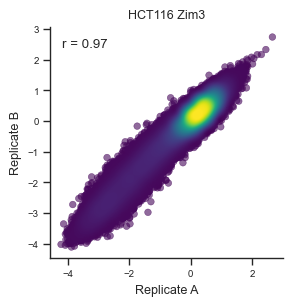

In [8]:
#plot correlation between replicate LFCs
plt.subplots(figsize=(3,3))
gpp.point_densityplot(data=lfc_df_HCT116_Zim3, x='HCT116_RDB182_RepA', y='HCT116_RDB182_RepB')
gpp.add_correlation(data=lfc_df_HCT116_Zim3, x='HCT116_RDB182_RepA', y='HCT116_RDB182_RepB')
sns.despine()
plt.xlabel('Replicate A',fontsize=9)
plt.ylabel('Replicate B',fontsize=9)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.title('HCT116 Zim3',fontsize=9)
gpp.savefig(figure1_outpath+'HCT116_Zim3_rep_corr.pdf',dpi=300, bbox_inches='tight')

In [9]:
lfc_df_HCT116_Zim3 = lfc_df_HCT116_Zim3[['Construct Barcode','HCT116_RDB182_RepA','HCT116_RDB182_RepB']]

In [10]:
#calculate average LFC across replicates
avg_replicate_lfc_df_HCT116_Zim3 = pool.average_replicate_lfcs(lfcs=lfc_df_HCT116_Zim3, guide_col='Construct Barcode', condition_indices=[0],sep='_')
avg_replicate_lfc_df_HCT116_Zim3.head()

,Construct Barcode,condition,avg_lfc,n_obs
0,AAAAAAAAAAATTAGACCTC,HCT116,-0.277625,2
1,AAAAAAAAAACAGGACACAG,HCT116,-0.144109,2
2,AAAAAAAAAACGTTGTGCAG,HCT116,0.035482,2
3,AAAAAAAAAAGGTCATTCAG,HCT116,-0.265074,2
4,AAAAAAAAAAGTGATCAGTT,HCT116,-0.135512,2


In [11]:
avg_replicate_lfc_df_HCT116_Zim3.rename(columns={'Construct Barcode':'sgRNA Sequence'}, inplace = True)

In [12]:
#z-score guide LFCs relative to intergenic controls
annot_guide_lfcs_HCT116_Zim3 = pool.annotate_guide_lfcs(avg_replicate_lfc_df_HCT116_Zim3, ess_noness, 'Target Gene Symbol',
                                            merge_on='sgRNA Sequence', z_score_neg_ctls=True,
                                            z_score_neg_ctl_genes='ONE_INTERGENIC')
annot_guide_lfcs_HCT116_Zim3.head()

,sgRNA Sequence,condition,avg_lfc,n_obs,Target Gene Symbol,Target Gene ID,Category,TSS Position,sgRNA 'Cut' Site TSS Offset,sgRNA Context Sequence,On-Target Ruleset,On-Target Efficacy Score,z_scored_avg_lfc
0,AAAAAAAAAAATTAGACCTC,HCT116,-0.277625,2,MRGPRD,116512.0,Non-essential,68980986.0,-735.0,AAAAAAAAAAAAAAATTAGACCTCAGGGCA,RS3seq-Chen2013,-0.6309,-1.315569
1,AAAAAAAAAACAGGACACAG,HCT116,-0.144109,2,LARS2,23395.0,Essential,45388577.0,667.0,CAGAAAAAAAAAAACAGGACACAGGGGAGA,RS3seq-Chen2013,0.0140,-0.992358
2,AAAAAAAAAACGTTGTGCAG,HCT116,0.035482,2,PRAMEF4,400735.0,Non-essential,12886201.0,393.0,CCTCAAAAAAAAAACGTTGTGCAGAGGAGG,RS3seq-Chen2013,-0.7256,-0.557609
3,AAAAAAAAAAGGTCATTCAG,HCT116,-0.265074,2,OR6K6,128371.0,Non-essential,158754721.0,-24.0,CTAGAAAAAAAAAAGGTCATTCAGGGGTCC,RS3seq-Chen2013,-0.1532,-1.285187
4,AAAAAAAAAAGTGATCAGTT,HCT116,-0.135512,2,IGBP1,3476.0,Essential,70133448.0,-448.0,AATAAAAAAAAAAAGTGATCAGTTTGGAAA,RS3seq-Chen2013,-0.4114,-0.971547


In [13]:
annot_guide_lfcs_HCT116_Zim3.to_csv(file_path + 'HCT116_Zim3_zscored.csv', index = False)